# Data Processing

Determine which laps to keep while avoiding eliminating all first laps. Bleh.
1. Import telemetry .csv
1. Import image data
1. Convert image data
1. Save image, telemetry, and target datasets

In [1]:
## Imports
import os
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

2022-05-09 00:47:14.166083: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
seed = 1337
np.random.seed(seed)

In [3]:
## Configuration
equalize_classes = True
dataset_max_size = 100_000
image_format = 'png' # jpg, png
lap_min_cutoff = 18
lap_max_cutoff = 20

# negative values shift "upwards", which will associate the screen with my actual reaction to it
target_shift = -3

# Telemetry
# imu_data = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',]
telemetry_data = ['speed', 'pitch', 'yaw', 'roll', 'first_lap']
telemetry_columns = telemetry_data

In [4]:
# Directories
data_directory = Path('../data')
records_directory = data_directory / 'records'
datasets_directory = data_directory / 'datasets' / time.strftime("%m_%d_%Y/%H_%M_%S")

# File paths
image_dataset_file = datasets_directory / 'X_img.npy'
telem_dataset_file = datasets_directory / 'X_telem.pkl'
target_dataset_file = datasets_directory / 'y.npy'

# For plotting
combined_laps_file = datasets_directory / 'processed_laps.pkl'
first_laps_file = datasets_directory / 'first_laps.pkl'
later_laps_file = datasets_directory / 'later_laps.pkl'
lap_stats_csv = datasets_directory / 'lap_stats.csv'

## Make sure directoires exist
os.makedirs(data_directory, exist_ok=True)
os.makedirs(datasets_directory, exist_ok=True)

In [5]:
csv_files = list(records_directory.glob('**/data.csv'))
n_files = len(csv_files)
data_dfs = []

for csv_path in csv_files:
    temp_df = pd.read_csv(csv_path, index_col=False)
    temp_df['folder'] = csv_path.parts[-3] + '/' + csv_path.parts[-2]
    # shift if required
    temp_df.loc[ :, ['steering', 'throttle']] = temp_df.loc[ :, ['steering', 'throttle']].shift(target_shift)
    # remove partial pre-first and last laps
    temp_df = temp_df.loc[(temp_df['lap'] != 0) & (temp_df['lap'] != temp_df['lap'].max()), :]
    data_dfs.append(temp_df.copy())
df = pd.concat(data_dfs)
df = df.reset_index(drop=True).copy()
df.head()
data_dfs = None
del data_dfs

### EDA/Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973656 entries, 0 to 973655
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   steering    973656 non-null  float64
 1   throttle    973656 non-null  float64
 2   speed       973656 non-null  float64
 3   image       973656 non-null  object 
 4   hit         973656 non-null  object 
 5   time        973656 non-null  float64
 6   accel_x     973656 non-null  float64
 7   accel_y     973656 non-null  float64
 8   accel_z     973656 non-null  float64
 9   gyro_x      973656 non-null  float64
 10  gyro_y      973656 non-null  float64
 11  gyro_z      973656 non-null  float64
 12  pitch       973656 non-null  float64
 13  yaw         973656 non-null  float64
 14  roll        973656 non-null  float64
 15  cte         973656 non-null  float64
 16  activeNode  973656 non-null  object 
 17  totalNodes  973656 non-null  object 
 18  pos_x       973656 non-null  float64
 19  po

#### Drop NAs
(These can exist due to the time shift, if any)

In [7]:
print(f'null records: {df.isna().sum().sum()}')
df = df.dropna().copy()

null records: 0


#### Convert dtypes to save space (?)

In [8]:
# print(f"before: {sys.getsizeof(df)}")

# for col in df.columns:
#     if df[col].dtype == 'float':
#         df[col] = pd.to_numeric(df[col], downcast='float')

# int_cols = ['activeNode','lap']
# for ic in int_cols:
#     df.loc[:,ic] = pd.to_numeric(df[ic], downcast='unsigned')

# print(f"after: {sys.getsizeof(df)}") 

### Lap Filters

#### Create lap data df

In [9]:
df['folder_lap'] = df['folder'] + '_' + df['lap'].astype(str)

laps = pd.DataFrame(df.groupby(by='folder_lap')['time'].describe()[['max', 'min']])
laps['full'] = df.groupby(by='folder_lap')['activeNode'].nunique() > 245 # some wiggle room but seems to be moot now
laps['clean'] = df.groupby(by='folder_lap')['hit'].nunique() == 1 # only hit nothing

laps.head()

,max,min,full,clean
folder_lap,,,,
04_03_2022/12_43_08_1,50.09274,29.74274,True,True
04_03_2022/12_43_51_1,93.02274,72.72274,True,False
04_03_2022/12_43_51_2,112.02270,93.07274,True,True
04_03_2022/12_45_47_1,209.57270,188.62270,True,True
04_03_2022/12_46_22_1,244.28270,224.23270,True,True


#### Calculate lap times

In [10]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    2607.000000
mean       18.623880
std         0.649898
min        18.099000
25%        18.300000
50%        18.400000
75%        18.700000
max        30.350002
Name: lap_time, dtype: float64

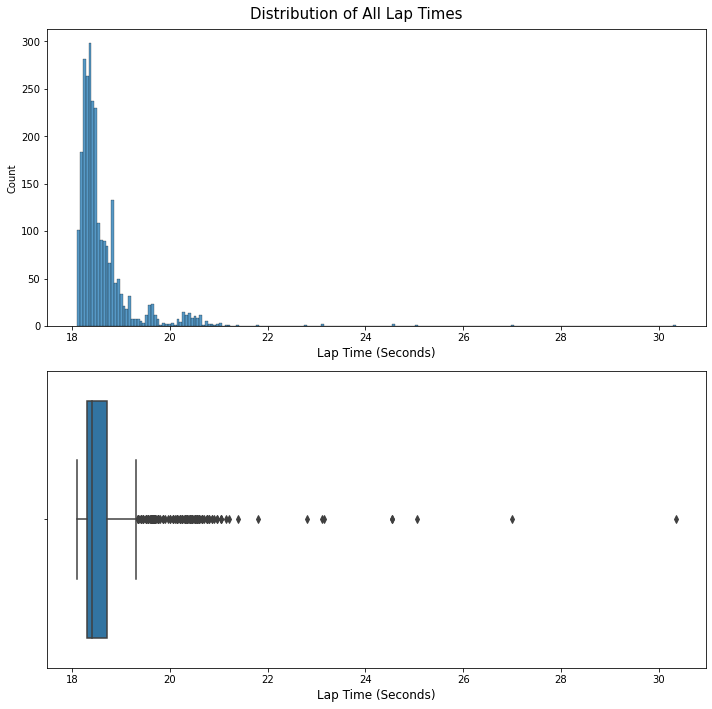

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of All Lap Times', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Filter df with lap data

In [12]:
## keep only full laps without collisions
df = df[list(laps.loc[df['folder_lap'],['clean', 'full']].all(axis=1))]

## merge in lap times
df = pd.merge(left=df, right=laps['lap_time'], left_on='folder_lap', right_index=True).copy()

## cut out laps that are too slow or too fast
df = df.loc[(df['lap_time'] < lap_max_cutoff) & (df['lap_time'] > lap_min_cutoff), :].copy()

df['lap_time'].describe()

count    645777.000000
mean         18.469126
std           0.304921
min          18.099000
25%          18.250000
50%          18.351000
75%          18.600000
max          19.700000
Name: lap_time, dtype: float64

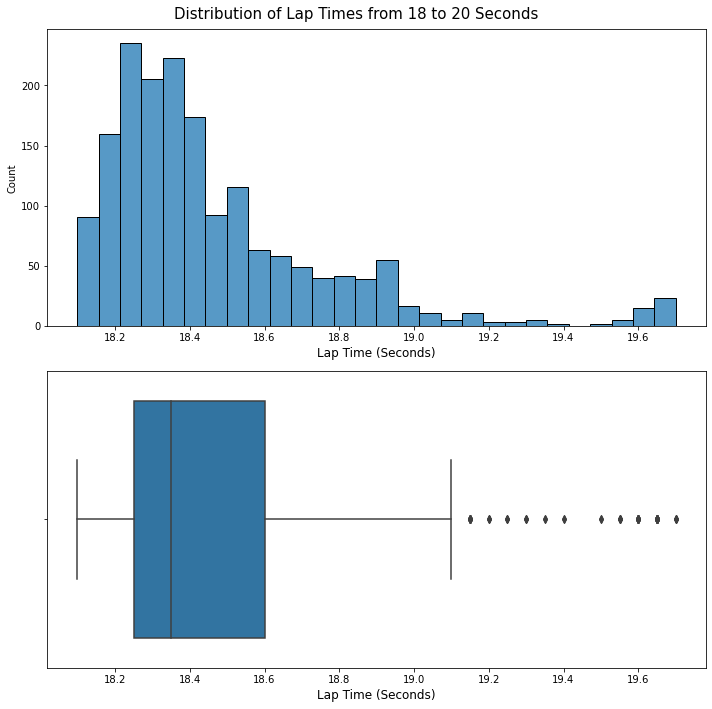

In [13]:
laps = pd.DataFrame(df.groupby(by='folder_lap')['time'].describe()[['max', 'min']])
laps['lap_time'] = laps['max'] - laps['min']

# laps = laps.loc[(laps['lap_time'] < lap_max_cutoff) & (laps['lap_time'] > lap_min_cutoff), :].copy()

fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle(f'Distribution of Lap Times from {lap_min_cutoff} to {lap_max_cutoff} Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Separate lap types

In [14]:
df_first_laps = df.loc[df['lap'] == 1, :].copy()
df_later_laps = df.loc[df['lap'] > 1, :].copy()

#### First laps

In [15]:
print(f"First laps: {len(df_first_laps['folder_lap'].unique())}")
df_first_laps['lap_time'].describe()

First laps: 41


count    16135.000000
mean        19.626886
std          0.039948
min         19.550000
25%         19.600000
50%         19.649990
75%         19.650000
max         19.700000
Name: lap_time, dtype: float64

##### Pare outliers from first laps

In [16]:
first_lap_cut = 20 # entirely arbitrary
print(f"records before cut: {len(df_first_laps)}") #.loc[df_first_laps['lap_time'] <= first_lap_cut, :])}")
print(f'laps before cut: {len(df_first_laps["folder_lap"].unique())}\n---------')
df_first_laps = df_first_laps.loc[df_first_laps['lap_time'] <= first_lap_cut, :].copy()
print(f'records after cut: {len(df_first_laps)}')
print(f'laps after cut: {len(df_first_laps["folder_lap"].unique())}')

records before cut: 16135
laps before cut: 41
---------
records after cut: 16135
laps after cut: 41


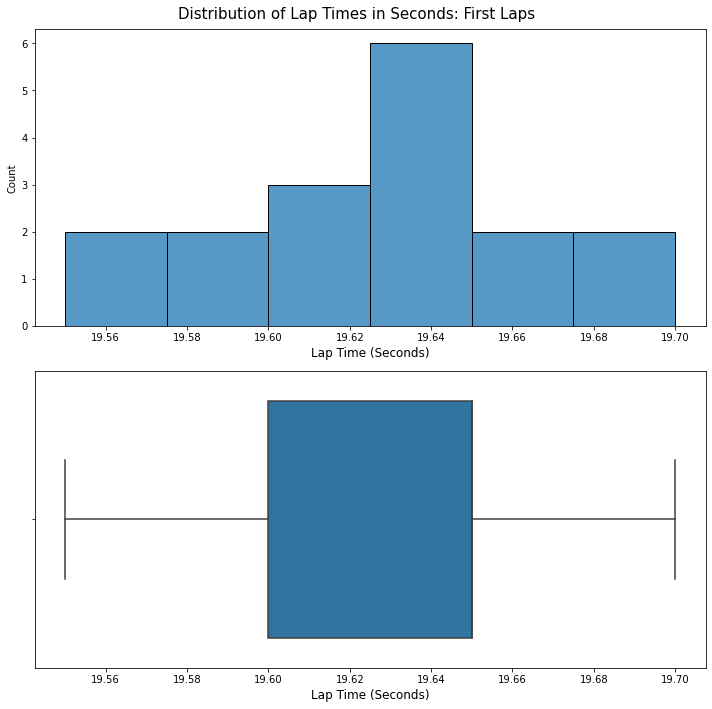

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds: First Laps', size=15)
ax[0] = sns.histplot(x=df_first_laps['lap_time'].unique(), bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x=df_first_laps['lap_time'].unique(), ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Later laps

In [18]:
df_later_laps['lap_time'].describe()

count    629642.000000
mean         18.439458
std           0.245132
min          18.099000
25%          18.250000
50%          18.350000
75%          18.550000
max          19.650000
Name: lap_time, dtype: float64

##### Pare outliers from later lap times

In [19]:
later_lap_cut = 18.20 # again, arbitrary
# print(f"less than {later_lap_cut} = {len(df_later_laps.loc[df_later_laps['lap_time'] <= later_lap_cut, :])}")
print(f'records after cut: {len(df_later_laps)}')
print(f'laps before cut: {len(df_later_laps["folder_lap"].unique())}\n---------')
df_later_laps = df_later_laps.loc[df_later_laps['lap_time'] <= later_lap_cut, :].copy()

print(f"records after cut: {len(df_later_laps.loc[df_later_laps['lap_time'] <= later_lap_cut, :])}")
print(f'laps after cut: {len(df_later_laps.loc[df_later_laps["lap_time"] <= later_lap_cut, "folder_lap"].unique())}')

records after cut: 629642
laps before cut: 1703
---------
records after cut: 62681
laps after cut: 172


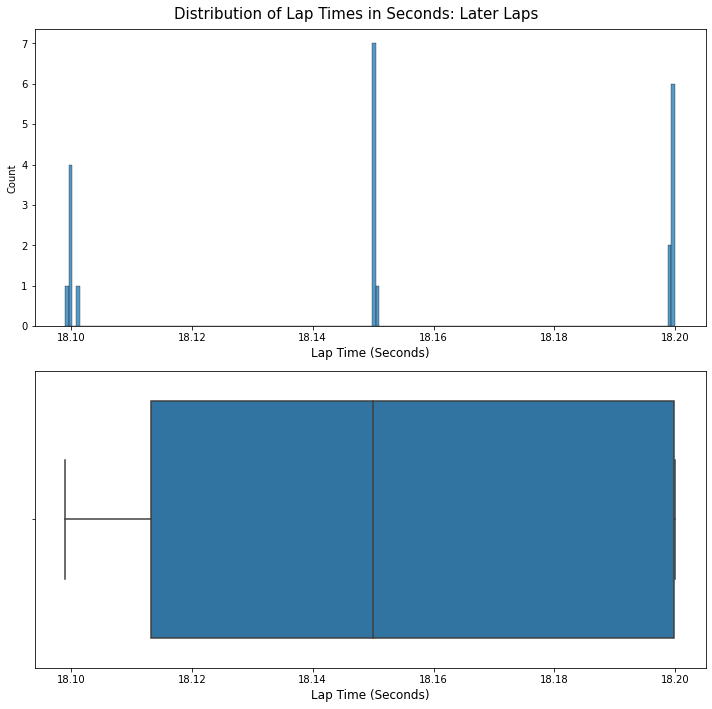

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds: Later Laps', size=15)
ax[0] = sns.histplot(x=df_later_laps['lap_time'].unique(), ax=ax[0], bins=165) #bins=(len(df_later_laps['lap_time'].unique())//10), ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x=df_later_laps['lap_time'].unique(), ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Mark lap types

In [21]:
df_first_laps.loc[:, 'lap_type'] = 'first'
df_later_laps.loc[:, 'lap_type'] = 'later'

In [22]:
print(f"{len(df_first_laps) = }")
print(f"{len(df_later_laps) = }")      

len(df_first_laps) = 16135
len(df_later_laps) = 62681


#### Equalize Lap Counts

In [23]:
if equalize_classes:
    if len(df_first_laps) < len(df_later_laps):
        df_first_laps = pd.concat([df_first_laps, df_first_laps.sample( (len(df_later_laps)-len(df_first_laps)), replace=True, random_state=seed)])
    if len(df_first_laps) > len(df_later_laps):
        df_later_laps = pd.concat([df_later_laps, df_later_laps.sample( (len(df_first_laps)-len(df_later_laps)), replace=True, random_state=seed)])

In [24]:
print(f"{len(df_first_laps) = }")
print(f"{len(df_later_laps) = }")      

len(df_first_laps) = 62681
len(df_later_laps) = 62681


#### Combine pared laps

In [25]:
df = pd.concat([df_first_laps, df_later_laps], ignore_index=True)
if 'first_lap' in telemetry_columns:
    df['first_lap'] = (df['lap_type'] == 'first') * 1

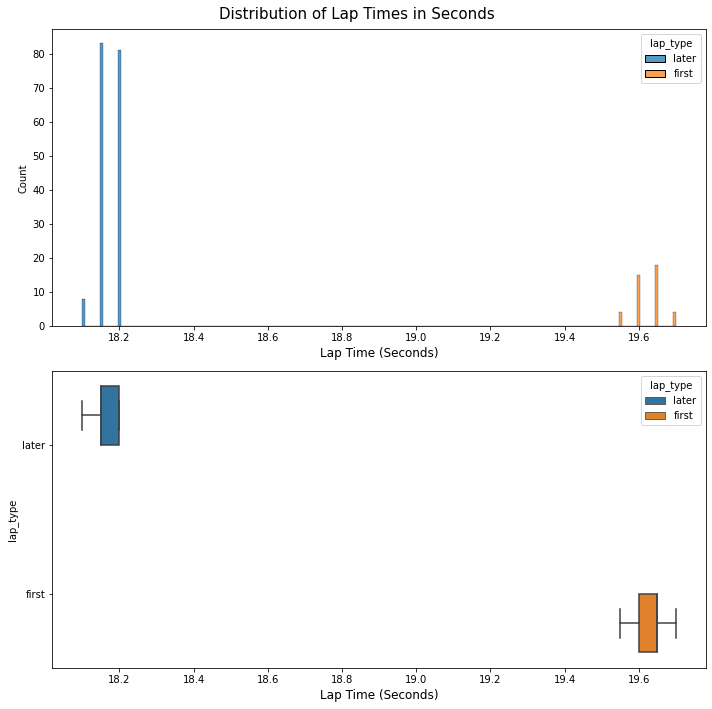

In [26]:
combined_laps = pd.DataFrame(df.groupby(by='folder_lap')['time'].describe()[['max', 'min']])
combined_laps['lap_time'] = laps['max'] - laps['min']
combined_laps['lap_type'] = df.groupby(by='folder_lap')['lap_type'].describe()[['top']]

fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=combined_laps, hue='lap_type', bins=100, ax=ax[0], multiple='dodge',)# log_scale=(0, 10))
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', y='lap_type', data=combined_laps, hue='lap_type', ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Save lap data (in time order) for plotting

In [27]:
for d in [df, df_first_laps, df_later_laps]:
    d = d.sort_values(by=['folder_lap', 'time'], ascending=True).copy()
    d = d.reset_index(drop=True).copy()

df.to_pickle(combined_laps_file)
df_first_laps.to_pickle(first_laps_file)
df_later_laps.to_pickle(later_laps_file)

In [28]:
len(df)

125362

### Shuffle/Pare Data

In [29]:
df = df.sample(n=min(len(df),dataset_max_size), random_state=seed).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   steering    100000 non-null  float64
 1   throttle    100000 non-null  float64
 2   speed       100000 non-null  float64
 3   image       100000 non-null  object 
 4   hit         100000 non-null  object 
 5   time        100000 non-null  float64
 6   accel_x     100000 non-null  float64
 7   accel_y     100000 non-null  float64
 8   accel_z     100000 non-null  float64
 9   gyro_x      100000 non-null  float64
 10  gyro_y      100000 non-null  float64
 11  gyro_z      100000 non-null  float64
 12  pitch       100000 non-null  float64
 13  yaw         100000 non-null  float64
 14  roll        100000 non-null  float64
 15  cte         100000 non-null  float64
 16  activeNode  100000 non-null  object 
 17  totalNodes  100000 non-null  object 
 18  pos_x       100000 non-null  float64
 19  pos

In [30]:
df['lap_type'].value_counts()

first    50156
later    49844
Name: lap_type, dtype: int64

## Telemetry

In [31]:
if 'first_lap' in telemetry_columns:
    df['first_lap'] = (df['lap'] == 1) * 1

In [32]:
X_telem = df[telemetry_columns]
X_telem

,speed,pitch,yaw,roll,first_lap
0,24.73447,358.895400,240.876700,359.065100,0
1,22.52995,355.894600,298.303300,4.365108,1
2,29.55147,2.115480,42.791160,352.305400,1
3,24.42375,0.235134,209.782700,1.897224,0
4,16.47673,3.268170,232.704100,12.899000,1
...,...,...,...,...,...
99995,26.91833,0.328073,5.431309,355.642800,0
99996,29.45354,1.721909,39.636260,353.090800,0
99997,22.17486,358.025500,353.266800,4.314892,1
99998,25.12543,1.745164,356.531600,3.842681,0


## Images

In [33]:
image_files = records_directory / df['folder'] / 'images' / df['image']

In [34]:
counter = 0
X_img = np.ndarray(shape=(len(image_files), 120, 160, 1),
                     dtype=np.uint8)

def load_images(im):
    global counter
    global X_img
    X_img[counter] = img_to_array(load_img(im, color_mode='grayscale'))
    counter += 1
    if not counter % 1000:
        print(f'> {counter}', end=' ')
        if not counter % 10000:
            print()

print(f'processing {len(image_files)} image files') 
image_files.apply(load_images)
print('done')
X_img.shape

processing 100000 image files
> 1000 > 2000 > 3000 > 4000 > 5000 > 6000 > 7000 > 8000 > 9000 > 10000 
> 11000 > 12000 > 13000 > 14000 > 15000 > 16000 > 17000 > 18000 > 19000 > 20000 
> 21000 > 22000 > 23000 > 24000 > 25000 > 26000 > 27000 > 28000 > 29000 > 30000 
> 31000 > 32000 > 33000 > 34000 > 35000 > 36000 > 37000 > 38000 > 39000 > 40000 
> 41000 > 42000 > 43000 > 44000 > 45000 > 46000 > 47000 > 48000 > 49000 > 50000 
> 51000 > 52000 > 53000 > 54000 > 55000 > 56000 > 57000 > 58000 > 59000 > 60000 
> 61000 > 62000 > 63000 > 64000 > 65000 > 66000 > 67000 > 68000 > 69000 > 70000 
> 71000 > 72000 > 73000 > 74000 > 75000 > 76000 > 77000 > 78000 > 79000 > 80000 
> 81000 > 82000 > 83000 > 84000 > 85000 > 86000 > 87000 > 88000 > 89000 > 90000 
> 91000 > 92000 > 93000 > 94000 > 95000 > 96000 > 97000 > 98000 > 99000 > 100000 
done


(100000, 120, 160, 1)

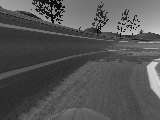

In [35]:
## Double check
Image.fromarray(X_img[0].reshape(120,160))

## Datasets

### Create Targets

In [36]:
## Target: throttle and steering data
y = df.loc[:, ['steering', 'throttle']] #.to_numpy().copy()

## Verify size
print(f'len(X_telem): {len(X_telem)}')
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

len(X_telem): 100000
X.shape: (100000, 120, 160, 1)
y.shape: (100000, 2)


### Save Datasets

In [37]:
## Save telemetry as pickle (why?)
X_telem.to_pickle(telem_dataset_file)

In [38]:
X_img = np.asarray([np.asarray(img) for img in X_img])

In [39]:
## Save as images and targets as binary NumPy .npy format
with open(image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)